# FSI problem

### This is a FSI problem of 2D cylinder of diameter 1 free falling in a quiescent flow

Considering the fictitious fluid inside the cylinder due to immersed boundary method, body density set in the code should be set to a different value. For example if you want to set $\rho = 3$, the density set in the code should be $\rho-1=2$. If you want to set $\rho = 2$, the density set in the code should be $\rho-1=1$.

To keep consistency between *Dyn3d* and *ViscousFlow*, the cylinder is setup in z-x coordinates, so gravity should also be set in z direction

In [1]:
using Pkg
Pkg.activate("..")
using FSI

In [2]:
using Revise
using BSON: @save, @load

using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [47]:
filename = "FallingCylinder";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [4]:
ndim = 2
# numerical params
tf = 1.0
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0.0, -1.0]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
function circle(z₀::Vector{Float64}, r::Float64, n::Int)
    # z₀ for circle center location, r for radius and n for # of points on circle
    verts = zeros(n,2)
    for i = 1:n
        verts[i,:] = [r*cos(2π/(n)*(i-1)) + z₀[1], r*sin(2π/(n)*(i-1)) + z₀[2]]
    end
    return verts
end

nbody = 1
nverts = 157
verts = circle([0.,0.], 0.5, nverts)
config_body = ConfigBody(nbody, nverts, verts, 1.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)

# set the first passive joint with no stiff and damp
dofₚ = Dof(6, "passive", 0., 0., Motions())
config_joints[1] = ConfigJoint(njoint, "custom_prismatic_in_z",
    [0.0,0.0,0.0,1.0,0.0,9.2], zeros(Float64,6), 0, [dofₚ], [0.0])

 joint type = custom_prismatic_in_z
 joint position in parent body coord = [0.0, 0.0, 0.0, 1.0, 0.0, 9.2]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 6, under passive motion
 initial unconstrained dof position = [0.0]


#### Build joint-body chain

In [5]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is un-mounted from space

#### Initialize rigid body system state to complete body-joint information

In [6]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [7]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [8]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

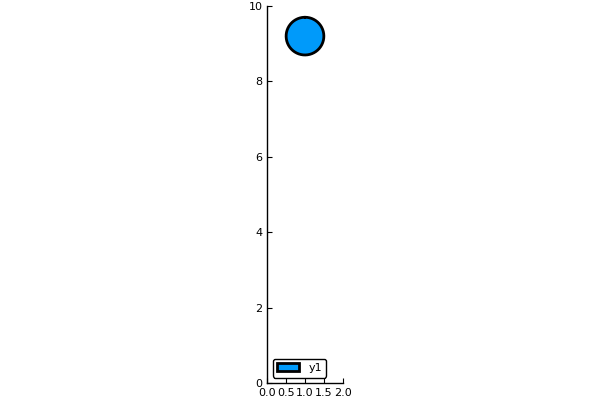

In [9]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,[1:nverts;1],1], vs₀[i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
end
plot!(xlims=(0,2), ylims=(0,10),ratio=1)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [10]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid

In [11]:
nx = 102; ny = 502;
Ly = 10.0;
Δx = Ly/(ny-2);

Δt = min(0.5*Δx,0.5*Δx^2*Re)

w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:2.0100000000000002, -0.01:0.02:10.01)

#### Set up fluid initial conditions

In [12]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Genrate body grid points and get linear velocity on them

In [13]:
# bgs short for body grid system
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx));

#### Get body points initial coordinates for fluids

In [14]:
bgs = AcquireBodyGridKinematics(bd,bgs)
coord_init = hcat(bgs[1].q_i...)'[:,[1,3]]
for i = 2:length(bgs)
    coord_init = [coord_init[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,3]]]
end

#### Set up body grid points and force container in fluid

In [15]:
X̃ = VectorData(coord_init)
f = VectorData(X̃);

#### Create fluidstruct structure

In [16]:
tf = 1000Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2
Δt

0.01

## <span style="color:blue"> Create ifherk object </span>

#### Here although we didn't use the format of considering buoyancy, buoyancy is already accounted for, since we set body density to $\rho-1$

In [17]:
function TimeMarching.F(bd::BodyDyn)
    f_exi = zeros(Float64,bd.sys.nbody,6)
    return HERKFuncf(bd.bs, bd.js, bd.sys, f_exi)
end

In [18]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M⁻¹, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx,"cylinder"),
                 (bd,bgs,u) -> T₂(bd,bgs,u,"cylinder"),
                 (bd,bgs) -> getX̃(bd,bgs,"cylinder")),
                ((w,t) -> FSI.r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3,rk=TimeMarching.RK31)

 26.110756 seconds (68.26 M allocations: 5.581 GiB, 4.45% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [19]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [20]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    if mod(round(Int,ti/Δt),200) == 1  
        @save filename*".bson" bd bdhist xg yg whist thist fx fy Δt w qJ v
        println("data saved at time ", ti)
    end
end

 22.693998 seconds (55.03 M allocations: 4.969 GiB, 3.33% gc time)
next time unit is 0.01
data saved at time 0.01
 20.178652 seconds (51.71 M allocations: 4.808 GiB, 3.35% gc time)
next time unit is 0.02
 20.868600 seconds (51.71 M allocations: 4.808 GiB, 3.31% gc time)
next time unit is 0.03
 23.965862 seconds (51.71 M allocations: 4.808 GiB, 3.32% gc time)
next time unit is 0.04
 20.830351 seconds (51.71 M allocations: 4.808 GiB, 3.12% gc time)
next time unit is 0.05
 20.419647 seconds (51.71 M allocations: 4.808 GiB, 3.13% gc time)
next time unit is 0.06
 20.420519 seconds (51.71 M allocations: 4.808 GiB, 3.16% gc time)
next time unit is 0.07
 20.407988 seconds (51.71 M allocations: 4.808 GiB, 3.55% gc time)
next time unit is 0.08
 20.470052 seconds (51.71 M allocations: 4.808 GiB, 3.12% gc time)
next time unit is 0.09
 20.475569 seconds (51.71 M allocations: 4.808 GiB, 3.12% gc time)
next time unit is 0.1
 20.415080 seconds (51.71 M allocations: 4.808 GiB, 3.12% gc time)
next time 

 21.255359 seconds (51.71 M allocations: 4.808 GiB, 3.08% gc time)
next time unit is 0.92
 21.092951 seconds (51.71 M allocations: 4.808 GiB, 3.09% gc time)
next time unit is 0.93
 21.297667 seconds (51.71 M allocations: 4.808 GiB, 3.11% gc time)
next time unit is 0.94
 20.266499 seconds (51.71 M allocations: 4.808 GiB, 3.58% gc time)
next time unit is 0.95
 20.163090 seconds (51.71 M allocations: 4.808 GiB, 3.08% gc time)
next time unit is 0.96
 20.149883 seconds (51.71 M allocations: 4.808 GiB, 3.11% gc time)
next time unit is 0.97
 20.333477 seconds (51.71 M allocations: 4.808 GiB, 3.07% gc time)
next time unit is 0.98
 20.370007 seconds (51.71 M allocations: 4.808 GiB, 3.09% gc time)
next time unit is 0.99
 20.296037 seconds (51.71 M allocations: 4.808 GiB, 3.54% gc time)
next time unit is 1.0
 20.203113 seconds (51.71 M allocations: 4.808 GiB, 3.08% gc time)
next time unit is 1.01
 20.588054 seconds (51.71 M allocations: 4.808 GiB, 3.11% gc time)
next time unit is 1.02
 20.192254 

 20.407090 seconds (51.71 M allocations: 4.808 GiB, 3.05% gc time)
next time unit is 1.84
 20.333192 seconds (51.71 M allocations: 4.808 GiB, 3.05% gc time)
next time unit is 1.85
 20.528461 seconds (51.71 M allocations: 4.808 GiB, 3.03% gc time)
next time unit is 1.86
 20.551638 seconds (51.71 M allocations: 4.808 GiB, 3.57% gc time)
next time unit is 1.87
 20.364644 seconds (51.71 M allocations: 4.808 GiB, 3.04% gc time)
next time unit is 1.88
 20.683951 seconds (51.71 M allocations: 4.808 GiB, 3.07% gc time)
next time unit is 1.89
 20.944716 seconds (51.71 M allocations: 4.808 GiB, 3.06% gc time)
next time unit is 1.9
 20.871477 seconds (51.71 M allocations: 4.808 GiB, 3.49% gc time)
next time unit is 1.91
 20.478704 seconds (51.71 M allocations: 4.808 GiB, 3.03% gc time)
next time unit is 1.92
 20.422741 seconds (51.71 M allocations: 4.808 GiB, 3.04% gc time)
next time unit is 1.93
 20.750652 seconds (51.71 M allocations: 4.808 GiB, 3.00% gc time)
next time unit is 1.94
 20.324823 

 18.839987 seconds (51.71 M allocations: 4.808 GiB, 3.03% gc time)
next time unit is 2.75
 18.960523 seconds (51.71 M allocations: 4.808 GiB, 3.44% gc time)
next time unit is 2.76
 18.813605 seconds (51.71 M allocations: 4.808 GiB, 3.02% gc time)
next time unit is 2.77
 18.733866 seconds (51.71 M allocations: 4.808 GiB, 3.03% gc time)
next time unit is 2.78
 25.646755 seconds (51.71 M allocations: 4.808 GiB, 2.65% gc time)
next time unit is 2.79
 22.618907 seconds (51.71 M allocations: 4.808 GiB, 3.20% gc time)
next time unit is 2.8
 20.208102 seconds (51.71 M allocations: 4.808 GiB, 2.94% gc time)
next time unit is 2.81
 19.770200 seconds (51.71 M allocations: 4.808 GiB, 2.96% gc time)
next time unit is 2.82
 19.031075 seconds (51.71 M allocations: 4.808 GiB, 3.02% gc time)
next time unit is 2.83
 19.224673 seconds (51.71 M allocations: 4.808 GiB, 3.46% gc time)
next time unit is 2.84
 19.304626 seconds (51.71 M allocations: 4.808 GiB, 2.97% gc time)
next time unit is 2.85
 19.088202 

 18.866000 seconds (51.71 M allocations: 4.808 GiB, 3.44% gc time)
next time unit is 3.67
 18.791748 seconds (51.71 M allocations: 4.808 GiB, 3.00% gc time)
next time unit is 3.68
 18.833228 seconds (51.71 M allocations: 4.808 GiB, 3.01% gc time)
next time unit is 3.69
 18.775821 seconds (51.71 M allocations: 4.808 GiB, 3.03% gc time)
next time unit is 3.7
 18.993352 seconds (51.71 M allocations: 4.808 GiB, 3.48% gc time)
next time unit is 3.71
 18.738990 seconds (51.71 M allocations: 4.808 GiB, 2.99% gc time)
next time unit is 3.72
 18.806847 seconds (51.71 M allocations: 4.808 GiB, 3.03% gc time)
next time unit is 3.73
 18.784148 seconds (51.71 M allocations: 4.808 GiB, 3.04% gc time)
next time unit is 3.74
 18.785238 seconds (51.71 M allocations: 4.808 GiB, 3.06% gc time)
next time unit is 3.75
 18.905287 seconds (51.71 M allocations: 4.808 GiB, 3.45% gc time)
next time unit is 3.76
 18.838817 seconds (51.71 M allocations: 4.808 GiB, 3.01% gc time)
next time unit is 3.77
 18.771990 

 18.898798 seconds (51.71 M allocations: 4.808 GiB, 3.48% gc time)
next time unit is 4.58
 18.803165 seconds (51.71 M allocations: 4.808 GiB, 3.00% gc time)
next time unit is 4.59
 18.762251 seconds (51.71 M allocations: 4.808 GiB, 3.00% gc time)
next time unit is 4.6
 18.820336 seconds (51.71 M allocations: 4.808 GiB, 3.04% gc time)
next time unit is 4.61
 18.802968 seconds (51.71 M allocations: 4.808 GiB, 3.05% gc time)
next time unit is 4.62
 18.927288 seconds (51.71 M allocations: 4.808 GiB, 3.45% gc time)
next time unit is 4.63
 18.802932 seconds (51.71 M allocations: 4.808 GiB, 3.03% gc time)
next time unit is 4.64
 18.828528 seconds (51.71 M allocations: 4.808 GiB, 3.01% gc time)
next time unit is 4.65
 18.867477 seconds (51.71 M allocations: 4.808 GiB, 3.06% gc time)
next time unit is 4.66
 18.884856 seconds (51.71 M allocations: 4.808 GiB, 3.46% gc time)
next time unit is 4.67
 18.784007 seconds (51.71 M allocations: 4.808 GiB, 3.00% gc time)
next time unit is 4.68
 19.071497 

 19.197537 seconds (51.71 M allocations: 4.808 GiB, 3.48% gc time)
next time unit is 5.5
 19.197261 seconds (51.71 M allocations: 4.808 GiB, 3.07% gc time)
next time unit is 5.51
 19.467838 seconds (51.71 M allocations: 4.808 GiB, 3.04% gc time)
next time unit is 5.52
 19.269930 seconds (51.71 M allocations: 4.808 GiB, 3.06% gc time)
next time unit is 5.53
 19.453998 seconds (51.71 M allocations: 4.808 GiB, 3.49% gc time)
next time unit is 5.54
 19.180632 seconds (51.71 M allocations: 4.808 GiB, 3.01% gc time)
next time unit is 5.55
 19.307097 seconds (51.71 M allocations: 4.808 GiB, 3.05% gc time)
next time unit is 5.56
 19.349512 seconds (51.71 M allocations: 4.808 GiB, 3.01% gc time)
next time unit is 5.57
 19.370975 seconds (51.71 M allocations: 4.808 GiB, 3.52% gc time)
next time unit is 5.58
 19.209949 seconds (51.71 M allocations: 4.808 GiB, 2.99% gc time)
next time unit is 5.59
 19.040558 seconds (51.71 M allocations: 4.808 GiB, 3.05% gc time)
next time unit is 5.6
 19.034606 s

 19.339228 seconds (51.71 M allocations: 4.808 GiB, 3.49% gc time)
next time unit is 6.41
 19.181539 seconds (51.71 M allocations: 4.808 GiB, 3.03% gc time)
next time unit is 6.42
 19.181531 seconds (51.71 M allocations: 4.808 GiB, 3.08% gc time)
next time unit is 6.43
 19.323948 seconds (51.71 M allocations: 4.808 GiB, 3.11% gc time)
next time unit is 6.44
 19.445074 seconds (51.71 M allocations: 4.808 GiB, 3.52% gc time)
next time unit is 6.45
 19.250465 seconds (51.71 M allocations: 4.808 GiB, 3.05% gc time)
next time unit is 6.46
 19.265082 seconds (51.71 M allocations: 4.808 GiB, 3.05% gc time)
next time unit is 6.47
 19.233669 seconds (51.71 M allocations: 4.808 GiB, 3.09% gc time)
next time unit is 6.48
 19.365697 seconds (51.71 M allocations: 4.808 GiB, 3.53% gc time)
next time unit is 6.49
 19.336394 seconds (51.71 M allocations: 4.808 GiB, 3.03% gc time)
next time unit is 6.5
 19.209137 seconds (51.71 M allocations: 4.808 GiB, 3.08% gc time)
next time unit is 6.51
 19.148161 

 19.316150 seconds (51.71 M allocations: 4.808 GiB, 3.06% gc time)
next time unit is 7.33
 19.339535 seconds (51.71 M allocations: 4.808 GiB, 3.08% gc time)
next time unit is 7.34
 19.346759 seconds (51.71 M allocations: 4.808 GiB, 3.09% gc time)
next time unit is 7.35
 19.343572 seconds (51.71 M allocations: 4.808 GiB, 3.14% gc time)
next time unit is 7.36
 19.476338 seconds (51.71 M allocations: 4.808 GiB, 3.50% gc time)
next time unit is 7.37
 19.249719 seconds (51.71 M allocations: 4.808 GiB, 3.12% gc time)
next time unit is 7.38
 19.264294 seconds (51.71 M allocations: 4.808 GiB, 3.11% gc time)
next time unit is 7.39
 19.379943 seconds (51.71 M allocations: 4.808 GiB, 3.15% gc time)
next time unit is 7.4
 19.482045 seconds (51.71 M allocations: 4.808 GiB, 3.55% gc time)
next time unit is 7.41
 19.264082 seconds (51.71 M allocations: 4.808 GiB, 3.04% gc time)
next time unit is 7.42
 19.313925 seconds (51.71 M allocations: 4.808 GiB, 3.10% gc time)
next time unit is 7.43
 19.247932 

 19.328838 seconds (51.71 M allocations: 4.808 GiB, 3.13% gc time)
next time unit is 8.24
 19.311410 seconds (51.71 M allocations: 4.808 GiB, 3.12% gc time)
next time unit is 8.25
 19.312455 seconds (51.71 M allocations: 4.808 GiB, 3.18% gc time)
next time unit is 8.26
 19.442498 seconds (51.71 M allocations: 4.808 GiB, 3.18% gc time)
next time unit is 8.27
 19.403162 seconds (51.71 M allocations: 4.808 GiB, 3.56% gc time)
next time unit is 8.28
 19.331448 seconds (51.71 M allocations: 4.808 GiB, 3.14% gc time)
next time unit is 8.29
 19.312274 seconds (51.71 M allocations: 4.808 GiB, 3.14% gc time)
next time unit is 8.3
 19.188711 seconds (51.71 M allocations: 4.808 GiB, 3.22% gc time)
next time unit is 8.31
 19.334465 seconds (51.71 M allocations: 4.808 GiB, 3.61% gc time)
next time unit is 8.32
 19.370646 seconds (51.71 M allocations: 4.808 GiB, 3.12% gc time)
next time unit is 8.33
 19.274696 seconds (51.71 M allocations: 4.808 GiB, 3.17% gc time)
next time unit is 8.34
 19.284440 

 19.292666 seconds (51.71 M allocations: 4.808 GiB, 3.20% gc time)
next time unit is 9.16
 19.292535 seconds (51.71 M allocations: 4.808 GiB, 3.22% gc time)
next time unit is 9.17
 19.270384 seconds (51.71 M allocations: 4.808 GiB, 3.23% gc time)
next time unit is 9.18
 19.458877 seconds (51.71 M allocations: 4.808 GiB, 3.63% gc time)
next time unit is 9.19
 19.320385 seconds (51.71 M allocations: 4.808 GiB, 3.16% gc time)
next time unit is 9.2
 19.373025 seconds (51.71 M allocations: 4.808 GiB, 3.18% gc time)
next time unit is 9.21
 19.290255 seconds (51.71 M allocations: 4.808 GiB, 3.21% gc time)
next time unit is 9.22
 19.535850 seconds (51.71 M allocations: 4.808 GiB, 3.68% gc time)
next time unit is 9.23
 19.340404 seconds (51.71 M allocations: 4.808 GiB, 3.16% gc time)
next time unit is 9.24
 19.301665 seconds (51.71 M allocations: 4.808 GiB, 3.13% gc time)
next time unit is 9.25
 19.499317 seconds (51.71 M allocations: 4.808 GiB, 3.18% gc time)
next time unit is 9.26
 19.466996 

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [22]:
contour_levels = range(-0.2,stop=0.2,length=50)
sample_freq = 5
fps = 25;

#### Get body verts history

In [23]:
# get verts info based on this regular grid solution
vshist = []
for i = 1:length(bdhist)
    push!(vshist, VertsHistory(bdhist[i].sys.nbody, bdhist[i].bs))
end

#### Plot first and last time field

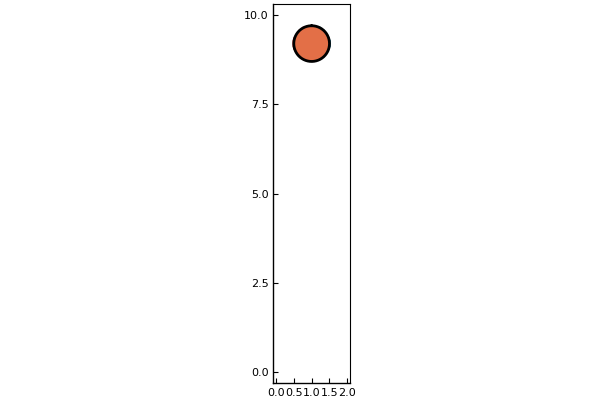

In [24]:
p = plot(xg,yg,whist[1],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,[1:nverts;1],1], vshist[1][i,[1:nverts;1],3],linewidth=2,linecolor="black", fill=true)
end
p

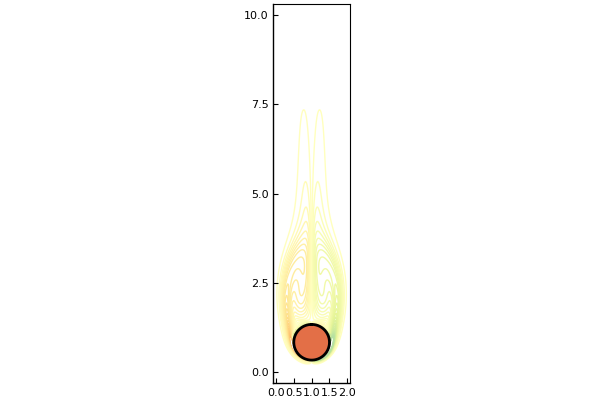

In [25]:
p = plot(xg,yg,whist[end],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,[1:nverts;1],1], vshist[end][i,[1:nverts;1],3],linewidth=2,linecolor="black", fill=true)
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

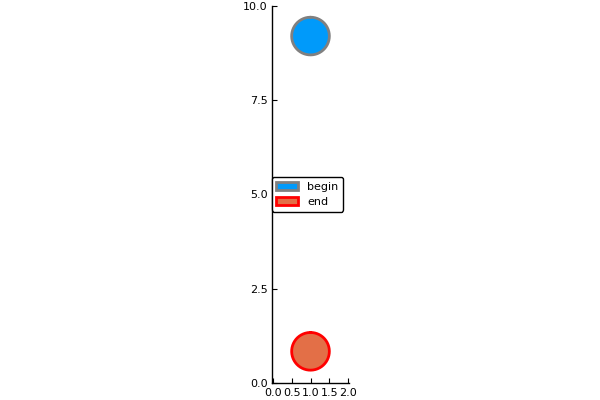

In [27]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,[1:nverts;1],1], vshist[1][i,[1:nverts;1],3],linewidth=2,linecolor="grey",label="begin",fill=true)
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,[1:nverts;1],1], vshist[end][i,[1:nverts;1],3],linewidth=2,linecolor="red",label="end",fill=true)
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1)
pb

#### Make gif

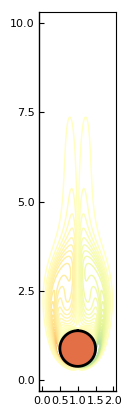

┌ Info: Saved animation to 
│   fn = /mnt/d/cylinder_validation/FSI.jl/examples/FallingCylinder_tmp.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/d/cylinder_validation/FSI.jl/examples/FallingCylinder_tmp.gif")

In [28]:
anim = @animate for j = 1:sample_freq:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels)
    for i = 1:sys.nbody
        plot!(vshist[j][i,[1:nverts;1],1], vshist[j][i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
    end
end
nothing

gif(anim, filename*".gif", fps = fps)

#### Get cylinder position and velocity in time

In [29]:
vhist = [0.0]
phist = [0.0]

for i in 1:length(bdhist)
    push!(vhist,bdhist[i].bs[1].v[6])
    push!(phist,bdhist[i].bs[1].x_i[3]-bdhist[1].bs[1].x_i[3])    
end

ahist = []
for i in 1:length(vhist)-1
    push!(ahist,(vhist[i+1]-vhist[i])/Δt)
end

#### Plot cylinder position, velocity, acceleration

In [30]:
# pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false,ylims=(-25,0))
# pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false,ylims=(-2,0))
# pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false,ylims=(-0.5,0))

# plot(pp,pv,pa)

In [31]:
ahist

1000-element Array{Any,1}:
 -0.3173694442487292  
 -0.31533192983703623 
 -0.3135806680036478  
 -0.31203402484992915 
 -0.3106396523861738  
 -0.30936280261090293 
 -0.3081795751059782  
 -0.3070729230636834  
 -0.30603037673796113 
 -0.3050425139864449  
 -0.30410195936141565 
 -0.3032026571969305  
 -0.30233991325207266 
  ⋮                   
 -0.0250633912658893  
 -0.02404781876133022 
 -0.022226783083079127
 -0.023582820893053302
 -0.022383234591649703
 -0.023828471843878596
 -0.022118267249870982
 -0.02271324051001944 
 -0.022862558903780084
 -0.02281146284328628 
 -0.02360517470996193 
 -0.018724748793585988

In [43]:
using CSV

pdata = CSV.read("local_run/validation/csv/position.csv",header=false)
xp = [pdata[i,1] for i in 1:length(pdata[1])]
yp = [pdata[i,2] for i in 1:length(pdata[2])]

vdata = CSV.read("local_run/validation/csv/velocity.csv",header=false)
xv = [vdata[i,1] for i in 1:length(vdata[1])]
yv = [vdata[i,2] for i in 1:length(vdata[2])]

# adata = CSV.read("local_run/validation/csv/acceleration.csv",header=false)
adata = CSV.read("local_run/validation/csv/a2.csv",header=false)
xa = [adata[i,1] for i in 1:length(adata[1])]
ya = [adata[i,2] for i in 1:length(adata[2])];

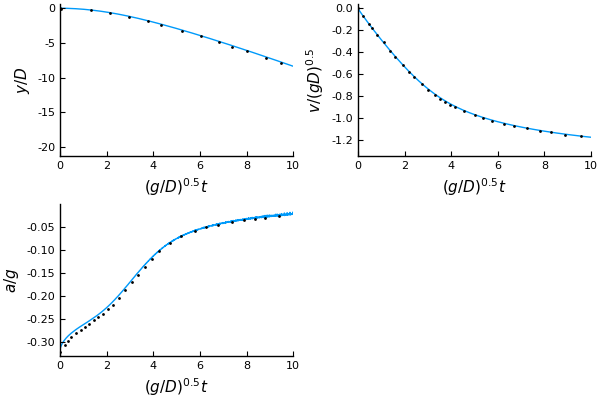

In [46]:
pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false,xlims=(0,10.0))
scatter!(pp,xp,yp,linestyle=:dot,markersize=1)
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false,xlims=(0,10.0))
scatter!(xv,yv,linestyle=:dot,markersize=1)
pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false,xlims=(0,10.0))
scatter!(xa,ya,linestyle=:dot,markersize=1)

plot(pp,pv,pa)

#### Lift and drag coefficients

In [34]:
fy

1000-element Array{Float64,1}:
 0.5359715666341793
 0.5373881660061256
 0.5386270614036592
 0.5397357552387779
 0.5407453726999366
 0.5416769862797164
 0.542545407755651 
 0.5433613733484877
 0.544132849801838 
 0.5448659429468223
 0.545565541032395 
 0.5462357854444251
 0.5468795386874986
 ⋮                 
 0.7619168070762888
 0.7660806470415115
 0.7667490903425683
 0.7661304578200583
 0.7668285688165973
 0.7650090503426691
 0.7669689740597574
 0.7669491000414229
 0.7651382158509928
 0.7667864661918846
 0.7664296990352025
 0.764149185149637 

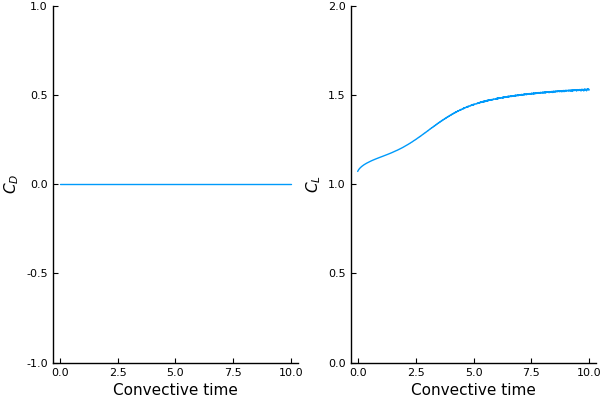

In [35]:
px = plot(thist,2*fx,ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0,2),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data .bson file

In [48]:
@save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [37]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);